In [ ]:
!pip install -U scikit-learn
!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

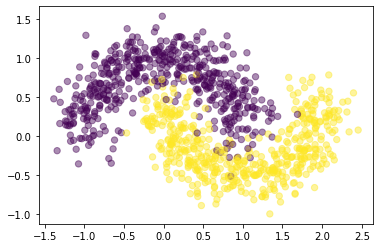

In [ ]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [ ]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [ ]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [ ]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 1000: 0.318194
Loss after iteration 2000: 0.297823
Loss after iteration 3000: 0.292968
Loss after iteration 4000: 0.289702
Loss after iteration 5000: 0.286239
Loss after iteration 6000: 0.282110
Loss after iteration 7000: 0.277041
Loss after iteration 8000: 0.270838
Loss after iteration 9000: 0.263436
Loss after iteration 10000: 0.254934
Loss after iteration 11000: 0.245598
Loss after iteration 12000: 0.235800
Loss after iteration 13000: 0.225928
Loss after iteration 14000: 0.216313
Loss after iteration 15000: 0.207199
Loss after iteration 16000: 0.198736
Loss after iteration 17000: 0.190997
Loss after iteration 18000: 0.183991
Loss after iteration 19000: 0.177694
Loss after iteration 20000: 0.172053
Loss after iteration 21000: 0.167009
Loss after iteration 22000: 0.162497
Loss after iteration 23000: 0.158456
Loss after iteration 24000: 0.154825
Loss after iteration 25000: 0.151550
Loss after iteration 26000: 0.148580
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

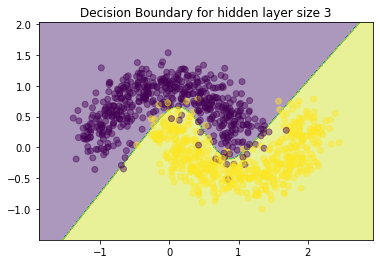

In [ ]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


In [ ]:
# your code here
# relu function
def relu(x):
    return np.maximum(0, x)

# loss function for a 3-layer MLP
def loss_2(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    return 1./num_examples * data_loss

# forward propagation
def predict_2(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_2(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_2(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_2)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_2(model)))
    
    return model

Loss after iteration 0: 0.608912
Loss after iteration 1000: 0.311934
Loss after iteration 2000: 0.298569
Loss after iteration 3000: 0.288616
Loss after iteration 4000: 0.282558
Loss after iteration 5000: 0.278322
Loss after iteration 6000: 0.274588
Loss after iteration 7000: 0.271157
Loss after iteration 8000: 0.268137
Loss after iteration 9000: 0.265536
Loss after iteration 10000: 0.263403
Loss after iteration 11000: 0.261632
Loss after iteration 12000: 0.259982
Loss after iteration 13000: 0.258600
Loss after iteration 14000: 0.257437
Loss after iteration 15000: 0.256455
Loss after iteration 16000: 0.255620
Loss after iteration 17000: 0.254908
Loss after iteration 18000: 0.254268
Loss after iteration 19000: 0.253696
Loss after iteration 20000: 0.253180
Loss after iteration 21000: 0.252752
Loss after iteration 22000: 0.252393
Loss after iteration 23000: 0.252078
Loss after iteration 24000: 0.251814
Loss after iteration 25000: 0.251594
Loss after iteration 26000: 0.251395
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

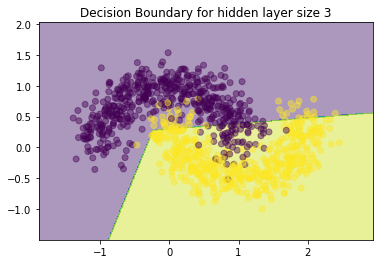

In [ ]:
# Plot the decision boundary
# Build a model with a 3-dimensional hidden layer
model_2 = build_model_2(3, print_loss=True)
plot_decision_boundary(lambda x: predict_2(model_2, x))
plt.title("Decision Boundary for hidden layer size 3")

## We can see that ReLU, being a max(0, x), i.e. a linear function, is unable to solve this problem with only 3 neurons. So we will need more neurons.

Loss after iteration 0: 1.122715
Loss after iteration 1000: 0.327489
Loss after iteration 2000: 0.283248
Loss after iteration 3000: 0.268079
Loss after iteration 4000: 0.257320
Loss after iteration 5000: 0.238474
Loss after iteration 6000: 0.201532
Loss after iteration 7000: 0.162188
Loss after iteration 8000: 0.130299
Loss after iteration 9000: 0.112425
Loss after iteration 10000: 0.103089
Loss after iteration 11000: 0.097997
Loss after iteration 12000: 0.095206
Loss after iteration 13000: 0.093574
Loss after iteration 14000: 0.092565
Loss after iteration 15000: 0.091905
Loss after iteration 16000: 0.091456
Loss after iteration 17000: 0.091141
Loss after iteration 18000: 0.090914
Loss after iteration 19000: 0.090748
Loss after iteration 20000: 0.090623
Loss after iteration 21000: 0.090527
Loss after iteration 22000: 0.090450
Loss after iteration 23000: 0.090386
Loss after iteration 24000: 0.090333
Loss after iteration 25000: 0.090287
Loss after iteration 26000: 0.090246
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 7')

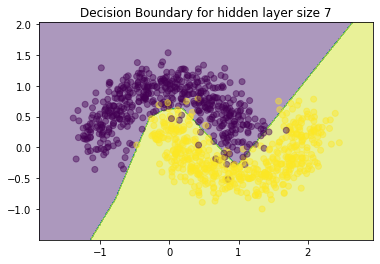

In [ ]:
# Plot the decision boundary
model_2 = build_model_2(7, print_loss=True)
plot_decision_boundary(lambda x: predict_2(model_2, x))
plt.title("Decision Boundary for hidden layer size 7")

## By adding more neurons we can see that we get more features to solve the problem, so it is able to make more cuts to classify the problem. We can see that the error is only 0.089.

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 


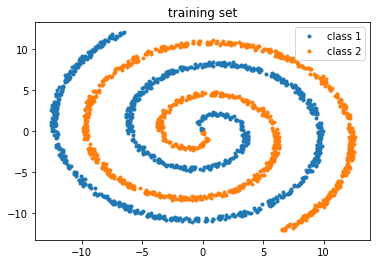

In [ ]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [ ]:
# your code here
num_examples = len(X) # training set size

In [ ]:
# your code here

# loss function for a 3-layer MLP
def loss_3(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = relu(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y.astype(int)])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)) + np.sum(np.square(W5)))
    return 1./num_examples * data_loss

# forward propagation
def predict_3(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    z1 = np.dot(x,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = relu(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_3(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_hdim))
    W4 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b4 = np.zeros((1, nn_hdim))
    W5 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_3(model, X)

        # computing the derivative by AD 
       
        gradient_loss = grad(loss_3)
        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_3(model)))
    
    return model

Loss after iteration 0: 0.747969
Loss after iteration 1000: 0.657726
Loss after iteration 2000: 0.645196
Loss after iteration 3000: 0.637165
Loss after iteration 4000: 0.628780
Loss after iteration 5000: 0.619821
Loss after iteration 6000: 0.607767
Loss after iteration 7000: 0.594387
Loss after iteration 8000: 0.579907
Loss after iteration 9000: 0.565708
Loss after iteration 10000: 0.537262
Loss after iteration 11000: 0.511644
Loss after iteration 12000: 0.482644
Loss after iteration 13000: 0.451774
Loss after iteration 14000: 0.422387
Loss after iteration 15000: 0.391372
Loss after iteration 16000: 0.361185
Loss after iteration 17000: 0.222951
Loss after iteration 18000: 0.140562
Loss after iteration 19000: 0.095656
Loss after iteration 20000: 0.060334
Loss after iteration 21000: 0.042280
Loss after iteration 22000: 0.031781
Loss after iteration 23000: 0.025151
Loss after iteration 24000: 0.020382
Loss after iteration 25000: 0.016922
Loss after iteration 26000: 0.014325
Loss after ite

Text(0.5, 1.0, 'Two spirals hidden layer size 9')

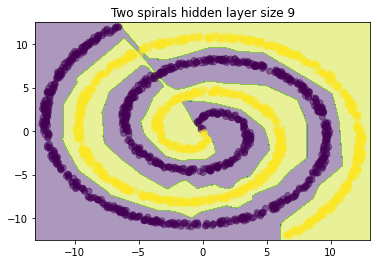

In [ ]:
# Build a model with a 9-dimensional hidden layer
model_3 = build_model_3(9, print_loss=True)
plot_decision_boundary(lambda x: predict_3(model_3, x))
plt.title("Two spirals hidden layer size 9")

## We can see that the previous neural network from exercise 1 is unable to solve the problem because there are not enough neurons and the network is too shallow. So by adding 9 neurons per layer and two more hidden layers with more iterations, we can solve the problem.

## In conclusion,
## Relu works well if we have a larger number of layers and also the iterations are much faster than with another activation function. Also a deeper network is better than a wide network is better.